# Object Localization with TensorFlow

Created for the Coursera Guided Project: [Object Localization with TensorFlow](https://www.coursera.org/projects/object-localization-tensorflow)

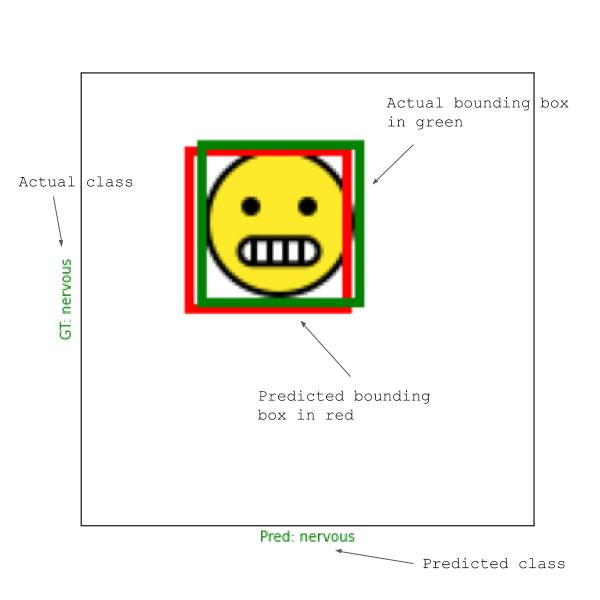

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

# Task 1: Check GPU

In [1]:
!nvidia-smi

Sun Apr 18 13:55:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Task 2: Download and Visualize Data

In [2]:
!wget -q https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
!rm -f -r emojis
!mkdir emojis
!unzip -q openmoji-72x72-color.zip -d ./emojis

In [3]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.4.1


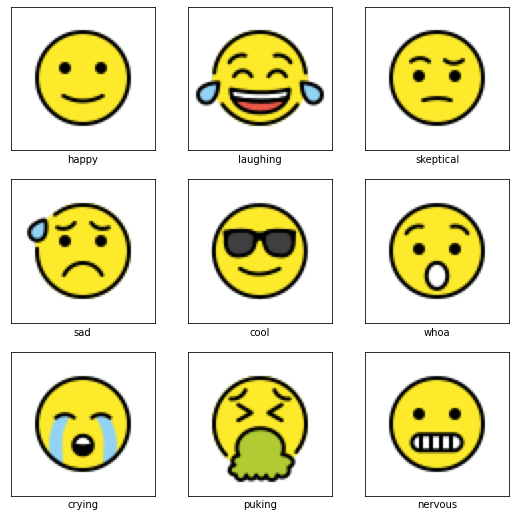

In [4]:
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Task 3: Create Examples

In [5]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [6]:
emojis

{0: {'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05F568C10>,
  'name': 'happy'},
 1: {'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05E49AD10>,
  'name': 'laughing'},
 2: {'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05F4B5610>,
  'name': 'skeptical'},
 3: {'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05E49AB90>,
  'name': 'sad'},
 4: {'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05E4951D0>,
  'name': 'cool'},
 5: {'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05F568FD0>,
  'name': 'whoa'},
 6: {'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05E4A1610>,
  'name': 'crying'},
 7: {'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72 at 0x7FE05E4A1590>,
  'name': 'puking'},
 8: {'file': '1F62C.png',
  'image'

In [7]:
def create_example():
    class_id = np.random.randint(0, 9)
    image = np.ones((144, 144, 3)) * 255
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    image[row:row+72, col:col+72, :] = np.array(emojis[class_id]['image'])
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144

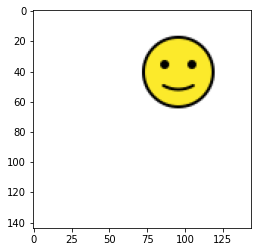

In [8]:
image, class_id, row, col = create_example()
plt.imshow(image)

## Task 4: Plot Bounding Boxes

In [9]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):
    if norm:
        image *= 255.
        image = image.astype('uint8')
    image = Image.fromarray(image)
    draw = ImageDraw.Draw(image)

    row, col = gt_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col+52, row+52), outline='green', width=3)

    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col+52, row+52), outline='red', width=3)
    return image

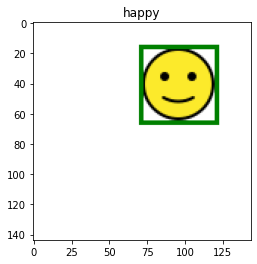

In [10]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Task 5: Data Generator

In [11]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 144, 144, 3))
        y_batch = np.zeros((batch_size, 9))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image /255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

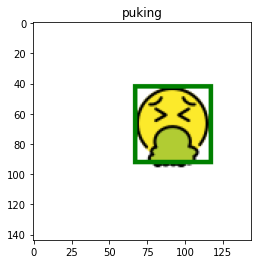

In [12]:
example, label = next(data_generator(1))
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]


image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Task 6: Model

In [13]:
input_ = Input(shape=(144, 144, 3), name='image')

x = input_

for i in range(0, 5):
    n_filters = 2**(4 + i)
    x = Conv2D(n_filters, 3, activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 144, 144, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 142, 142, 16) 448         image[0][0]                      
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 142, 142, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 71, 71, 16)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Task 7: Custom Metric: IoU

In [14]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2
        
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
    
    def result(self):
        return self.iou
    
    def reset_state(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')


## Task 8: Compile the Model

In [15]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',
        'box_out': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',
        'box_out': IoU(name='iou')
    }
)

## Task 9: Custom Callback: Model Testing

In [16]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']

    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color=color)
    plt.ylabel(f'GT: {gt}', color=color)
    plt.xticks([])
    plt.yticks([])

In [17]:
def test(model):
    test_datagen = data_generator(1)

    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()

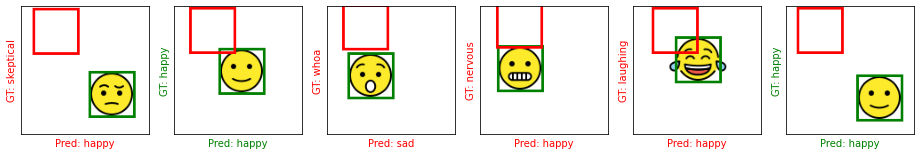

In [18]:
test(model)

In [19]:
class ShowTestImage(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

## Task 10: Model Training

Epoch 1/50
500/500 [==============================] - 14s 24ms/step - loss: 2.7123 - class_out_loss: 1.7080 - box_out_loss: 1.0043 - class_out_accuracy: 0.4249 - box_out_iou: -0.2050


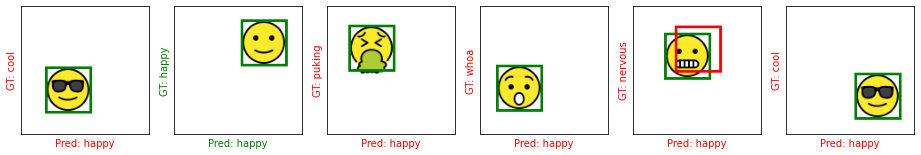

Epoch 2/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0552 - class_out_loss: 0.0152 - box_out_loss: 0.0400 - class_out_accuracy: 0.9997 - box_out_iou: 0.2588


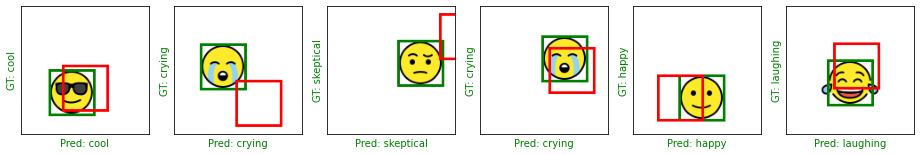

Epoch 3/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0184 - class_out_loss: 0.0035 - box_out_loss: 0.0149 - class_out_accuracy: 1.0000 - box_out_iou: 0.4084


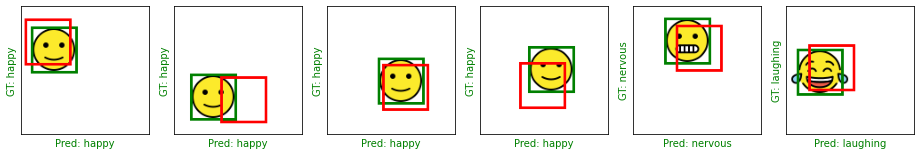

Epoch 4/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0097 - class_out_loss: 0.0018 - box_out_loss: 0.0079 - class_out_accuracy: 1.0000 - box_out_iou: 0.5125


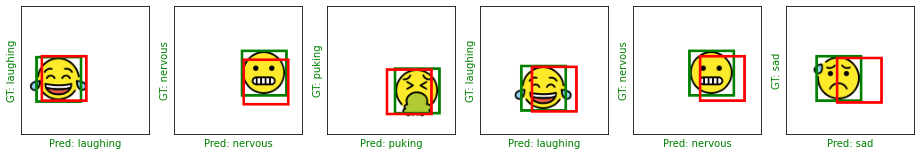

Epoch 5/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0041 - class_out_loss: 0.0010 - box_out_loss: 0.0031 - class_out_accuracy: 1.0000 - box_out_iou: 0.6465


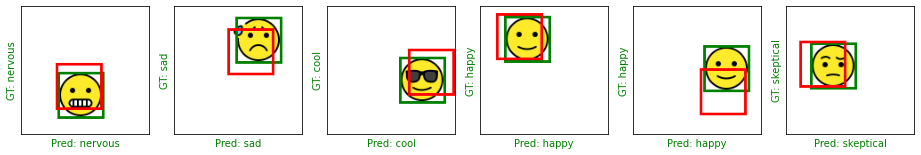

Epoch 6/50
500/500 [==============================] - 12s 24ms/step - loss: 0.0032 - class_out_loss: 6.9918e-04 - box_out_loss: 0.0025 - class_out_accuracy: 1.0000 - box_out_iou: 0.6732


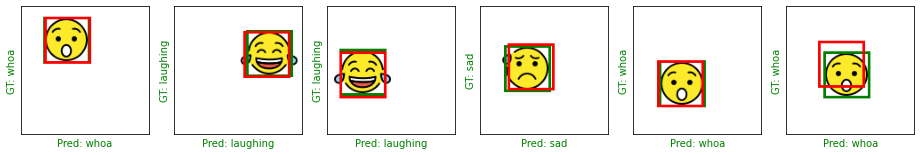

Epoch 7/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0029 - class_out_loss: 5.4345e-04 - box_out_loss: 0.0024 - class_out_accuracy: 1.0000 - box_out_iou: 0.6787


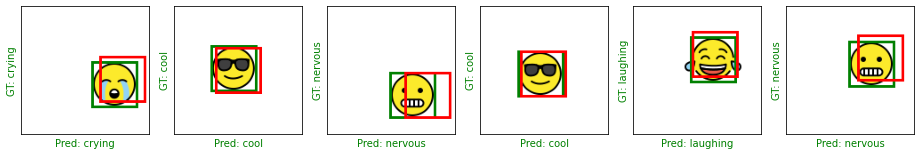

Epoch 8/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0027 - class_out_loss: 4.5533e-04 - box_out_loss: 0.0022 - class_out_accuracy: 1.0000 - box_out_iou: 0.6880


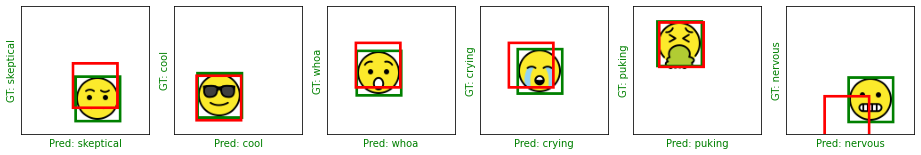

Epoch 9/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0024 - class_out_loss: 4.0505e-04 - box_out_loss: 0.0020 - class_out_accuracy: 1.0000 - box_out_iou: 0.7013


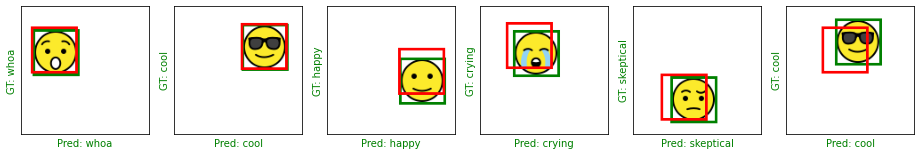

Epoch 10/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0019 - class_out_loss: 3.5830e-04 - box_out_loss: 0.0015 - class_out_accuracy: 1.0000 - box_out_iou: 0.7297


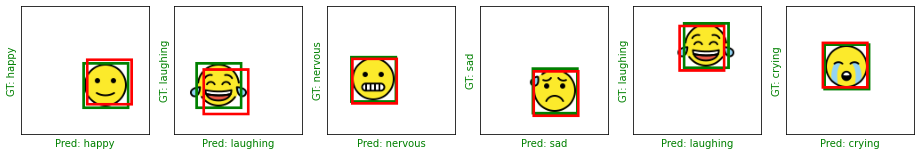

Epoch 11/50
500/500 [==============================] - 12s 25ms/step - loss: 0.0017 - class_out_loss: 3.3439e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7424


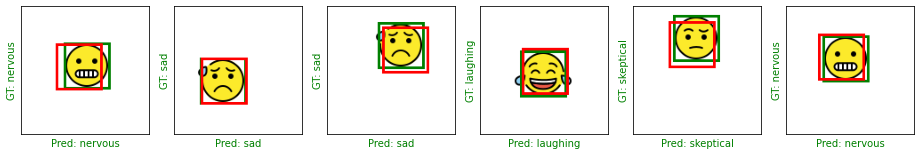

Epoch 12/50
500/500 [==============================] - 13s 25ms/step - loss: 0.0016 - class_out_loss: 2.8853e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7487


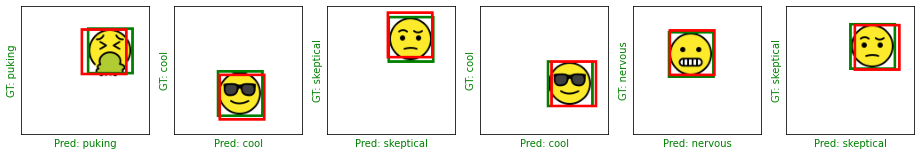

Epoch 13/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0016 - class_out_loss: 3.3562e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7473


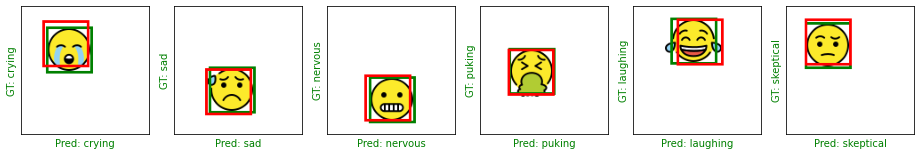

Epoch 14/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0018 - class_out_loss: 4.1546e-04 - box_out_loss: 0.0013 - class_out_accuracy: 1.0000 - box_out_iou: 0.7446


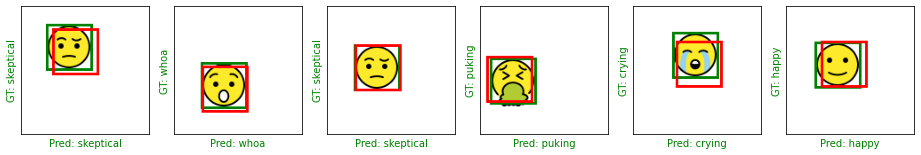

Epoch 15/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0014 - class_out_loss: 2.6091e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7630


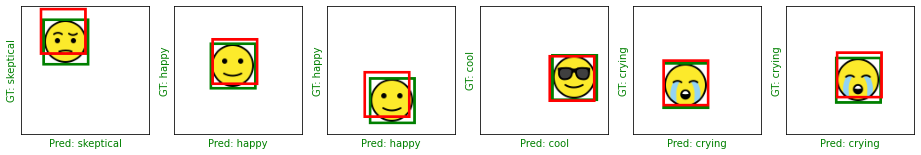

Epoch 16/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0013 - class_out_loss: 2.3582e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7683


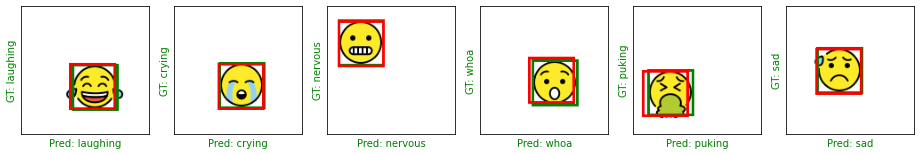

Epoch 17/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0013 - class_out_loss: 2.1941e-04 - box_out_loss: 0.0011 - class_out_accuracy: 1.0000 - box_out_iou: 0.7667


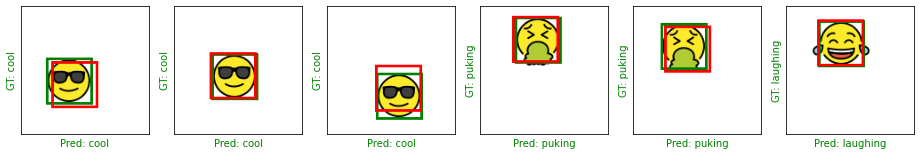

Epoch 18/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0012 - class_out_loss: 2.1283e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7719


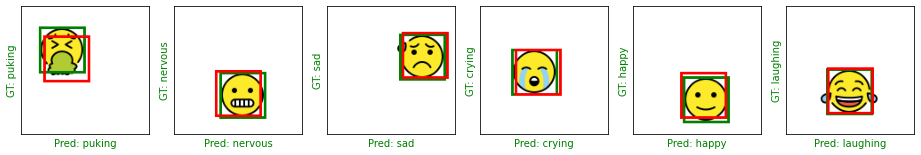

Epoch 19/50
500/500 [==============================] - 13s 26ms/step - loss: 0.0012 - class_out_loss: 2.1465e-04 - box_out_loss: 0.0010 - class_out_accuracy: 1.0000 - box_out_iou: 0.7708


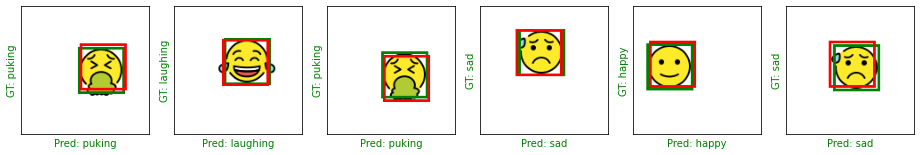

Epoch 20/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0012 - class_out_loss: 2.3673e-04 - box_out_loss: 9.7845e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7738


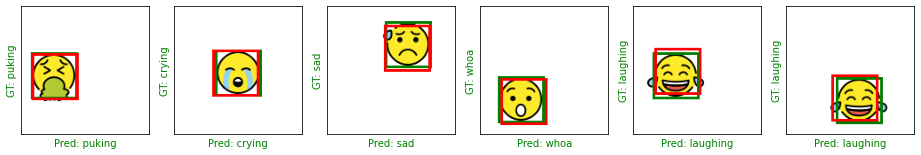

Epoch 21/50
500/500 [==============================] - 13s 27ms/step - loss: 0.0013 - class_out_loss: 3.2832e-04 - box_out_loss: 9.6962e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7756


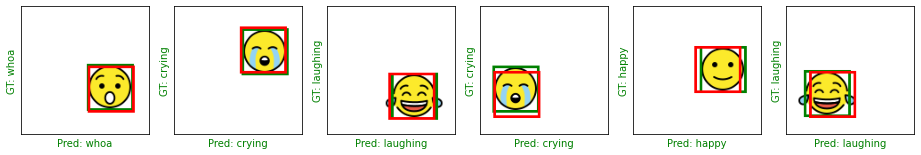

Epoch 22/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0012 - class_out_loss: 2.7873e-04 - box_out_loss: 9.6201e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7769


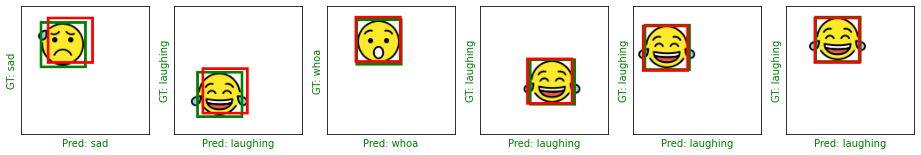

Epoch 23/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0012 - class_out_loss: 2.5498e-04 - box_out_loss: 9.3793e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7794


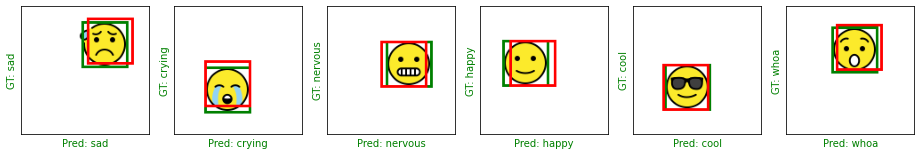

Epoch 24/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0011 - class_out_loss: 2.0469e-04 - box_out_loss: 9.2138e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7806


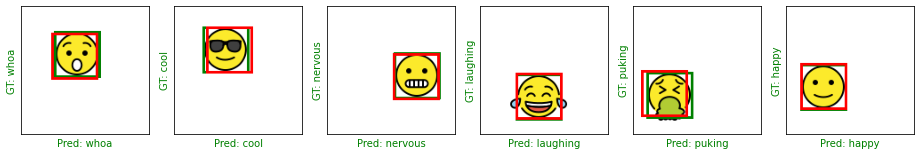

Epoch 25/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0011 - class_out_loss: 2.2165e-04 - box_out_loss: 9.1250e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7802


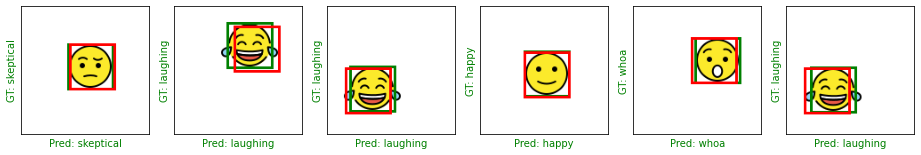

Epoch 26/50
500/500 [==============================] - 14s 27ms/step - loss: 0.0011 - class_out_loss: 2.0566e-04 - box_out_loss: 8.8962e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7831


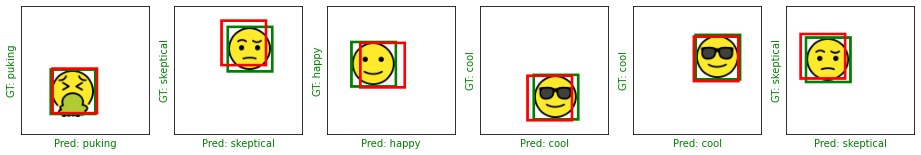

Epoch 27/50
500/500 [==============================] - 14s 28ms/step - loss: 0.0011 - class_out_loss: 2.1673e-04 - box_out_loss: 8.9708e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7834


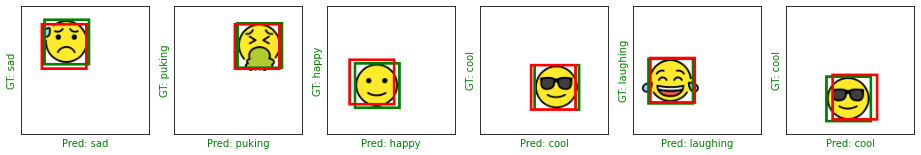

Epoch 28/50
500/500 [==============================] - 15s 29ms/step - loss: 0.0012 - class_out_loss: 2.3074e-04 - box_out_loss: 9.4660e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7786


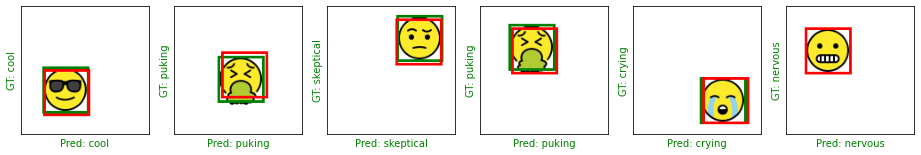

Epoch 29/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0011 - class_out_loss: 2.0155e-04 - box_out_loss: 8.8872e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7838


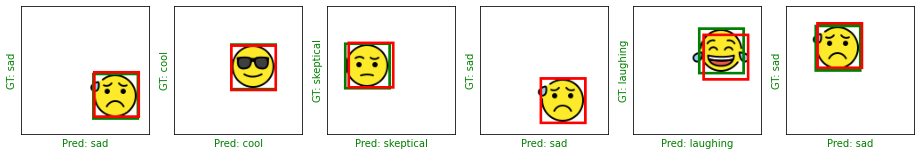

Epoch 30/50
500/500 [==============================] - 15s 30ms/step - loss: 0.0011 - class_out_loss: 2.1221e-04 - box_out_loss: 9.1406e-04 - class_out_accuracy: 1.0000 - box_out_iou: 0.7804


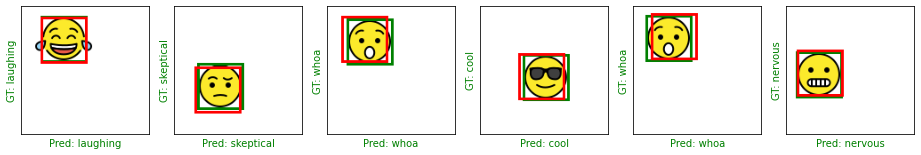

In [20]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)


_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImage(),
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'),
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

<div align='center'>

# Thank You

</div>